In [36]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.ripper import make_ripper_node
from architecture.utils import describe_architecture

In [37]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
input_values = dataset_df.drop(columns="class").to_numpy(bool)
target_values = dataset_df["class"].to_numpy(bool)

# balance
pos_idx = np.where(target_values == 1)[0]
neg_idx = np.where(target_values == 0)[0]

num_samples = min(len(pos_idx), len(neg_idx))

balanced_pos_idx = resample(pos_idx, n_samples=num_samples, replace=False, random_state=42)
balanced_neg_idx = resample(neg_idx, n_samples=num_samples, replace=False, random_state=42)

balanced_idx = np.concatenate([balanced_pos_idx, balanced_neg_idx])
input_values, target_values = input_values[balanced_idx], target_values[balanced_idx]

# split
input_values_train, input_values_test, target_values_train, target_values_test \
    = train_test_split(input_values, target_values, test_size=0.2, random_state=42, stratify=target_values)

print("Dataset shapes:")
print(f"TRAIN | input: {input_values_train.shape}, target: {target_values_train.shape}, pos. frac.: {target_values_train.mean():.3f}")
print(f"TEST  | input: {input_values_test.shape}, target: {target_values_test.shape}, pos. frac.: {target_values_test.mean():.3f}")

Dataset shapes:
TRAIN | input: (627, 10), target: (627,), pos. frac.: 0.501
TEST  | input: (157, 10), target: (157,), pos. frac.: 0.497


In [38]:
layer_node_counts = [4096] * 4
config = dict(layer_node_counts=layer_node_counts, layer_bit_counts=[2]*len(layer_node_counts), seed=42)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
%time net.fit(input_values_train, target_values_train)

pred_values_test = net.predict(input_values_test)
ref_values_test = np.broadcast_to(target_values_test[:, None], pred_values_test.shape)
accuracies_test = (pred_values_test == ref_values_test).mean(axis=0)

best_output_node_idx = int(np.argmax(accuracies_test))
best_output_node_name = net.node_names[-1][best_output_node_idx]

print("Best node:", best_output_node_name, "with accuracy", accuracies_test[best_output_node_idx])

CPU times: user 9.95 s, sys: 1.63 s, total: 11.6 s
Wall time: 33 s
Best node: L4N1813 with accuracy 0.9044585987261147


In [64]:
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import sympy as sp

mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",
    "font.weight": "bold"
})

def format_subscripts(name: str) -> str:
    """Format digits in names as subscripts (e.g. L2N7 -> $L_{2}N_{7}$)."""
    return "$" + re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", name) + "$"

def make_node_label(node, layer_name: str) -> str:
    """Create LaTeX label for a node, using subscripts and optional expression."""
    small = format_subscripts(node["name"])

    if layer_name == "INPUT":
        return f"{small}"

    expr = node.get("metadata", {}).get("expression", node["name"])
    latex_expr = sp.latex(sp.simplify(expr))
    latex_expr = re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", latex_expr)

    return f"{small}$:$\n${latex_expr}$"

def plot_architecture_networkx(
        desc,
        *,
        layer_separation: float = 3.2,
        node_separation: float = 1.35,
        input_separation: float = 1.35,
        node_font_size: float = 12.0,
        header_font_size: float = 14.0,
        edge_width: float = 1.6,
        dpi: int = 120
):
    graph = nx.DiGraph()
    node_positions, node_labels = {}, {}
    layer_node_separations = []

    # build graph & labels
    for lx, layer in enumerate(desc["layers"]):
        nodes = layer["nodes"]

        node_separations = input_separation if layer["name"] == "INPUT" else node_separation
        layer_node_separations.append(node_separations)

        y_pos = (np.arange(len(nodes))[::-1] - (len(nodes)-1)/2) * node_separations
        x_pos = np.full(len(nodes), lx * layer_separation)

        for i, node in enumerate(nodes):
            name = node["name"]
            node_positions[name] = (x_pos[i], y_pos[i])
            node_labels[name] = make_node_label(node, layer["name"])

            for backlink in node.get("backlinks", []):
                if backlink in node_positions:
                    graph.add_edge(backlink, name)

    # layout
    max_node_separation = max(layer_node_separations) if layer_node_separations else node_separation
    x_pad = 0.6 * layer_separation
    y_pad = 0.8 * max_node_separation
    h_off = 0.6 * max_node_separation

    y_vals = [p[1] for p in node_positions.values()] or [0.0]
    x_min, x_max = -x_pad, (len(desc["layers"])-1) * layer_separation + x_pad
    y_min, y_max = min(y_vals) - y_pad, max(y_vals) + y_pad + h_off

    figsize = ((x_max - x_min) * 0.9, (y_max - y_min) * 0.86)
    face, color = "white", "black"

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_facecolor(face)

    # edges
    nx.draw_networkx_edges(graph, node_positions, width=edge_width, edge_color=color, arrows=False, ax=ax, alpha=0.95)

    # nodes
    for name, (x, y) in node_positions.items():
        ax.text(x, y, node_labels[name], ha="center", va="center", fontsize=node_font_size, fontweight="bold", color=color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=face, edgecolor=color, linewidth=edge_width))

    # headers
    header_y = max(y_vals) + y_pad * 0.4 + h_off
    for lx, layer in enumerate(desc["layers"]):
        ax.text(lx * layer_separation, header_y, format_subscripts(layer["name"]),
                ha="center", va="bottom", color=color, fontweight="bold", fontsize=header_font_size)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    return fig, ax

In [65]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    for layer in net.layers:
        for node in layer:
            if hasattr(node, "reduce_expression"):
                node.reduce_expression()
    return net

# reduction per node is expensive, so its worth to do a pre-reduction pass
net.prune(output_node_names=[best_output_node_name])
net = reduce_ripper_net(net)
net.prune()

pred_values_test = net.predict(input_values_test)  # shape (N, 1)
accuracies_test = (pred_values_test == target_values_test).mean(axis=0)
print("Post-reduction accuracy:", accuracies_test)

Post-reduction accuracy: 0.9044585987261147


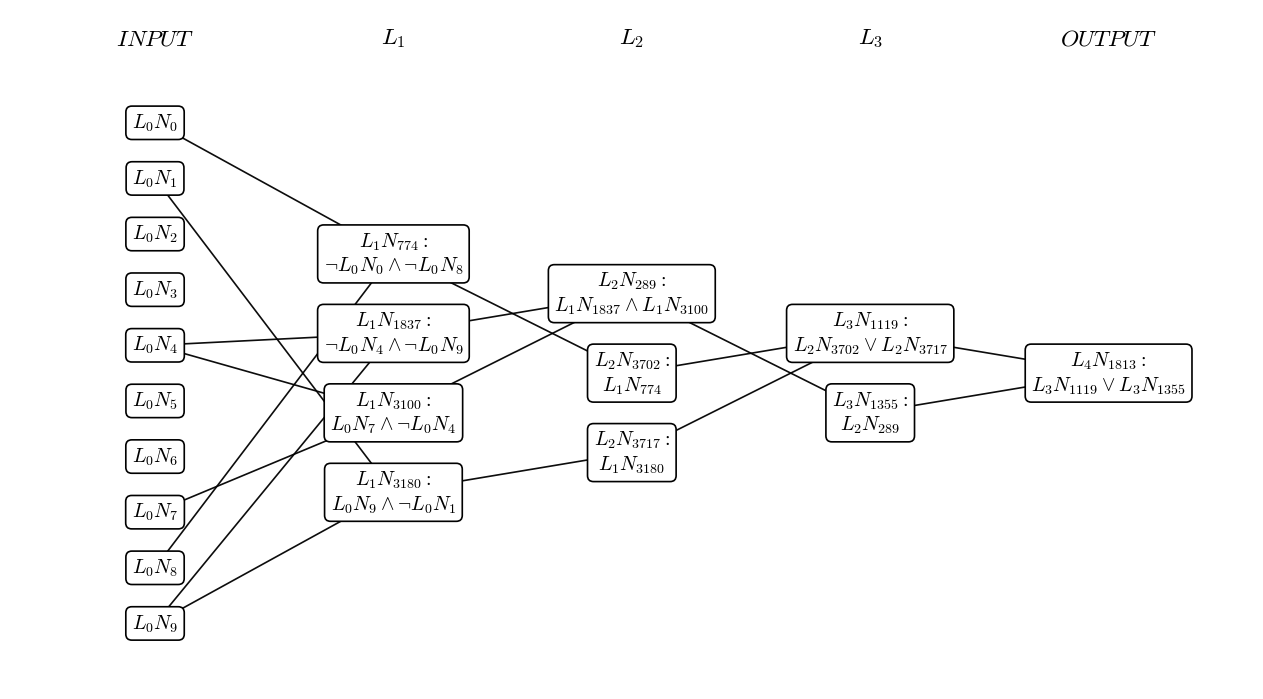

In [66]:
desc = describe_architecture(net)

fig, _ = plot_architecture_networkx(
    desc,
    layer_separation=3,
    node_separation=1,
    input_separation=0.7,
    header_font_size = 14.0,
    edge_width=1,
)

In [69]:
fig.savefig("./figures/ripper_binary_tree.png", dpi=300, bbox_inches="tight")